I used this tutorial https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from collections import Counter

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import tensorflow_hub as hub
from keras import backend as K
sess = tf.compat.v1.Session() 
K.set_session(sess)

plt.style.use("ggplot")


from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/NER_model/Architectures/')

raw_train = np.load('/content/drive/MyDrive/ColabNotebooks/NER_model/Architectures/TRAIN_DATA_np.npy', allow_pickle=True)
raw_test = np.load('/content/drive/MyDrive/ColabNotebooks/NER_model/Architectures/TEST_DATA_np.npy', allow_pickle=True)
dataset=np.concatenate((raw_train,raw_test), axis=0)
nltk.download('punkt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
print(len(raw_train),len(raw_test), len(dataset),4807 +2589)

4807 2589 7396 7396


In [5]:
sentences=[]
all_tokes=[]

for instance in raw_train:
    instance[0]=instance[0].replace("\tCopy", "")
    tokens=nltk.word_tokenize(instance[0])
    idx1=instance[1]['entities'][0][0]
    idx2=instance[1]['entities'][0][1]
    entity=instance[1]['entities'][0][2]
    sentence=[]
    for token in tokens:
        all_tokes.append(token)
        if token in instance[0][idx1:idx2].split():
            sentence.append((token,entity))
        else:
            sentence.append((token,'O'))
    sentences.append(sentence)

for instance in raw_test:
    instance[0]=instance[0].replace("\tCopy", "")
    tokens=nltk.word_tokenize(instance[0])
    idx1=instance[1][0][0]
    idx2=instance[1][0][1]
    entity=instance[1][0][2]
    sentence=[]
    for token in tokens:
        all_tokes.append(token)
        if token in instance[0][idx1:idx2].split():
            sentence.append((token,entity))
        else:
            sentence.append((token,'O'))
    sentences.append(sentence)


In [6]:
print(len(all_tokes))
words = set(list(map(str.lower, all_tokes)))
words.add('PADword')
n_words = len(words)
print(n_words)
tags = ['O','Device','Service','Resource']
n_tags = len(tags)
print(n_tags)
print(len(sentences))

150510
12073
4
7396


In [7]:
sentences

[[('It', 'O'),
  ('lays', 'O'),
  ('a', 'O'),
  ('certain', 'O'),
  ('theoretical', 'O'),
  ('foundation', 'O'),
  ('for', 'O'),
  ('giant', 'O'),
  ('magnetostrictive', 'O'),
  ('relay', 'Device'),
  ('actuator', 'Device'),
  ('being', 'O'),
  ('used', 'O'),
  ('in', 'O'),
  ('the', 'O'),
  ('fields', 'O'),
  ('of', 'O'),
  ('cutting', 'O'),
  ('with', 'O'),
  ('invariableness', 'O'),
  ('cutting', 'O'),
  ('force', 'O'),
  ('.', 'O')],
 [('He', 'O'),
  ("'s", 'O'),
  ('the', 'O'),
  ('repository', 'Resource'),
  ('of', 'O'),
  ('our', 'O'),
  ('common', 'O'),
  ('history', 'O'),
  (',', 'O'),
  ('and', 'O'),
  ('by', 'O'),
  ('that', 'O'),
  ('right', 'O'),
  (',', 'O'),
  ('grand', 'O'),
  ('patron', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('Bicentennial', 'O'),
  ('.', 'O')],
 [('Supply', 'O'),
  ('of', 'O'),
  ('ball', 'O'),
  ('valves', 'O'),
  ('of', 'O'),
  ('nominal', 'O'),
  ('diameter', 'O'),
  ('DN', 'O'),
  ('700', 'O'),
  ('full', 'O'),
  ('bore', 'O'),
  ('for', 'O'),
  (

biggest sentence has 115 words


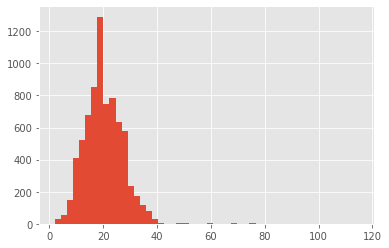

In [8]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [9]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['PADword'])
print(tags2index['O'])

max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

7036
0


['It',
 'has',
 'lifts',
 ',',
 'a',
 'coffee',
 'shop',
 ',',
 '7,000',
 'audio',
 'and',
 'visual',
 'items',
 ',',
 'an',
 'electronic',
 'MySQL',
 ',',
 'research',
 'engines',
 'and',
 '2,500',
 'metres',
 'of',
 'shelving',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [10]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [11]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.45, random_state=2018)


In [12]:
batch_size = 32
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]


input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
print(len(X_tr),len(X_te),len(y_tr),len(y_te))

4067 3329 4067 3329


In [14]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

X_tr, X_val = X_tr[:110*batch_size], X_tr[110*batch_size:]
y_tr, y_val = y_tr[:110*batch_size], y_tr[110*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [15]:
print(len(X_tr),len(X_te),len(y_tr),len(y_te),len(X_val),len(y_val))

3520 3329 3520 3329 547 547


In [16]:
history = model.fit(np.array(X_tr), y_tr, 
                    validation_data=(np.array(X_val[:-3]), y_val[:-3]),
                    batch_size=batch_size, epochs=3, verbose=1)

Train on 3520 samples, validate on 544 samples
Epoch 1/3
3520/3520 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9756

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3520/3520 [==============================] - 65s 19ms/sample - loss: 0.0771 - accuracy: 0.9756 - val_loss: 0.0268 - val_accuracy: 0.9908
Epoch 2/3
3520/3520 [==============================] - 57s 16ms/sample - loss: 0.0170 - accuracy: 0.9940 - val_loss: 0.0202 - val_accuracy: 0.9926
Epoch 3/3
3520/3520 [==============================] - 55s 16ms/sample - loss: 0.0109 - accuracy: 0.9962 - val_loss: 0.0149 - val_accuracy: 0.9950


In [18]:
!pip install seqeval[gpu]

     |████████████████████████████████| 43 kB 1.4 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=6ae2c6b8370206102dcc6e19041db2d15094927ce54f0238d9454cc2cc3bbb14
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [19]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
# X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te[:-1]), verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [20]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:-1])


In [21]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Service seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Resource seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Device seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


F1-score: 89.1%


In [22]:
print(classification_report(test_labels, pred_labels))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Service seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Resource seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Device seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

      ervice       0.95      0.89      0.92       764
     esource       0.94      0.91      0.92      1738
       evice       0.77      0.89      0.83      1083

   micro avg       0.88      0.90      0.89      3585
   macro avg       0.89      0.90      0.89      3585
weighted avg       0.89      0.90      0.89      3585



In [40]:
import nltk

In [81]:
userStory="""
As a Doctor, I want to the system to notify me about abnormality in sensor readings.
As a Doctor, I want to store in a database any abnormality in breathing of the patient.
As an Admin, I want to remove doctors and patients details of the MySQL.
As an Admin, I want to my iphone to alert me about some DDOS attacks.
As a Doctor, I want to upload a specific image and video of the patient.
"""
tokens=nltk.word_tokenize(userStory)
tokens=[tokens[:50]]*32
prediction=pred2label(model.predict(np.array(tokens), verbose=1))[0]

In [77]:
userStory="""
As a Doctor, I want to the system to notify me about abnormality in sensor readings.
As a Doctor, I want to store in a database any abnormality in breathing of the patient.
As an Admin, I want to remove doctors and patients details of the MySQL.
As an Admin, I want to my iphone to alert me about some DDOS attacks.
As a Doctor, I want to upload a specific image and video of the patient.
"""
tokens=nltk.word_tokenize(userStory)
tokens2=[tokens[50:]]*32
tt=[]
for seq in tokens2:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    tt.append(new_seq)
prediction2=pred2label(model.predict(np.array(tt), verbose=1))[0]

In [82]:
print(tokens[0])
print(prediction)

['As', 'a', 'Doctor', ',', 'I', 'want', 'to', 'the', 'system', 'to', 'notify', 'me', 'about', 'abnormality', 'in', 'sensor', 'readings', '.', 'As', 'a', 'Doctor', ',', 'I', 'want', 'to', 'store', 'in', 'a', 'database', 'any', 'abnormality', 'in', 'breathing', 'of', 'the', 'patient', '.', 'As', 'an', 'Admin', ',', 'I', 'want', 'to', 'remove', 'doctors', 'and', 'patients', 'details', 'of']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Device', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Resource', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [80]:
print(tt[0])
print(prediction2)

['the', 'MySQL', '.', 'As', 'an', 'Admin', ',', 'I', 'want', 'to', 'my', 'iphone', 'to', 'alert', 'me', 'about', 'some', 'DDOS', 'attacks', '.', 'As', 'a', 'Doctor', ',', 'I', 'want', 'to', 'upload', 'a', 'specific', 'image', 'and', 'video', 'of', 'the', 'patient', '.', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword']
['O', 'Resource', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [87]:
userStory="""
As a Doctor, I want to the system to notify me about abnormality in sensor readings.
As a Doctor, I want to store in a database any abnormality in breathing of the patient.
As an Admin, I want to remove doctors and patients details of the MySQL.
As an Admin, I want to my iphone to alert me about some DDOS attacks.
As a Doctor, I want to upload a specific image and video of the patient.
"""
for sentence in userStory.split('.'):
  tokens=nltk.word_tokenize(sentence)
  tokens=[tokens]*32
  tt=[]
  for seq in tokens:
      new_seq = []
      for i in range(max_len):
          try:
              new_seq.append(seq[i])
          except:
              new_seq.append("PADword")
      tt.append(new_seq)
  prediction=pred2label(model.predict(np.array(tt), verbose=1))
  print(tt[0])
  print(prediction[0])

['As', 'a', 'Doctor', ',', 'I', 'want', 'to', 'the', 'system', 'to', 'notify', 'me', 'about', 'abnormality', 'in', 'sensor', 'readings', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Device', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['As', 'a', 'Doctor', ',', 'I', 'want', 'to', 'store', 'in', 'a', 'database', 'any', 'abnormality', 'in', 'breathing', 'of', 'the', 'patient', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'P